# 1. Import modules

In [3]:
# standard libraries
from pathlib import Path
from dataclasses import dataclass

# Visualization
import matplotlib.pyplot as plt

# scientific computing
import pandas as pd


# plotting style
plt.style.use("../../config/DIT_HAP.mplstyle")
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]
AX_WIDTH, AX_HEIGHT = plt.rcParams["figure.figsize"]

# 2. Configuration

In [ ]:
@dataclass
class Config:
    project_dir: Path = Path("../../results/HD_DIT_HAP_generationRAW")
    

In [5]:
# Configuration and Constants
# =============================================================================

# File paths
COVERED_GENES_FILE = Path("../../results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv")
GENOME_ANNOTATION_FILE = Path("../../resources/pombase_data/2025-06-01/Gene_metadata/gene_IDs_names_products.tsv")
FYPO_VIABILITY_FILE = Path("../../resources/pombase_data/2025-06-01/Gene_metadata/FYPOviability.tsv")
DELETION_LIBRARY_ESSENTIALITY_FILE = Path("../../resources/Hayles_2013_OB_merged_categories_sysIDupdated.xlsx")
INSERTION_FILE_BEFORE_IMPUTATION = Path("../../results/HD_DIT_HAP/13_filtered/raw_reads.filtered.tsv")
INSERTION_FILE_AFTER_IMPUTATION = Path("../../results/HD_DIT_HAP/14_imputed_missing_values_using_FR/imputed_raw_reads.tsv")
ANNOTATION_FILE = Path("../../results/HD_DIT_HAP/12_concatenated/annotations.tsv")
OUTPUT_DIR = Path("../../results/HD_DIT_HAP/22_gene_coverage_analysis")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Gene product categories to exclude from "functional" gene analysis
EXCLUDED_GENE_PRODUCTS = {
    "dubious",
    "retrotransposable element/transposon Tf2-type"
}

# Visualization settings using custom color palette
COLORS = {
    'covered': '#962955',      # Deep pink-purple
    'not_covered': '#7fb775',  # Medium green
    'functional': '#6479cc',   # Medium blue
    'excluded': '#ad933c',     # Golden brown
    'background': '#f8f9fa'    # Light gray
}

# Plot settings
plt.rcParams.update({
    'figure.figsize': (8, 6),
    'font.size': 12,
    'font.family': 'Arial',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'grid.alpha': 0.3,
    'legend.frameon': False
})

logger.info("Configuration loaded successfully")
print("✓ Configuration and constants defined")
print("✓ Color palette and plot settings configured")


2025-07-27 18:47:48,722 - INFO - Configuration loaded successfully


✓ Configuration and constants defined
✓ Color palette and plot settings configured


## 1. Data Loading and Validation

Loading the two main datasets:
1. **Covered genes**: Genes with transposon insertions that passed curve fitting
2. **Genome annotation**: Complete gene metadata including gene types and products


In [3]:
def load_and_validate_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load and validate the input datasets.
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: covered_genes_df, genome_annotation_df
    
    Raises:
        FileNotFoundError: If input files don't exist
        ValueError: If data validation fails
    """
    logger.info("Loading input datasets...")
    
    # Load covered genes data
    if not COVERED_GENES_FILE.exists():
        raise FileNotFoundError(f"Covered genes file not found: {COVERED_GENES_FILE}")
    
    covered_genes_df = pd.read_csv(COVERED_GENES_FILE, sep='\t')
    logger.info(f"Loaded {len(covered_genes_df)} covered genes")

    # Load FYPO viability data
    if not FYPO_VIABILITY_FILE.exists():
        raise FileNotFoundError(f"FYPO viability file not found: {FYPO_VIABILITY_FILE}")

    fypo_viability_df = pd.read_csv(FYPO_VIABILITY_FILE, sep='\t', header=None, names=["gene_systematic_id", "FYPOviability"])
    logger.info(f"Loaded {len(fypo_viability_df)} FYPO viability data")

    # Load Deletion library essentiality data
    if not DELETION_LIBRARY_ESSENTIALITY_FILE.exists():
        raise FileNotFoundError(f"Deletion library essentiality file not found: {DELETION_LIBRARY_ESSENTIALITY_FILE}")

    deletion_essentiality_df = pd.read_excel(DELETION_LIBRARY_ESSENTIALITY_FILE)
    logger.info(f"Loaded {len(deletion_essentiality_df)} Deletion library essentiality data")

    # Load genome annotation data
    if not GENOME_ANNOTATION_FILE.exists():
        raise FileNotFoundError(f"Genome annotation file not found: {GENOME_ANNOTATION_FILE}")
    
    genome_annotation_df = pd.read_csv(GENOME_ANNOTATION_FILE, sep='\t')
    logger.info(f"Loaded {len(genome_annotation_df)} total genes from genome annotation")
    
    # add FYPOviability and DeletionLibrary_essentiality to genome_annotation_df
    genome_annotation_df = pd.merge(genome_annotation_df, fypo_viability_df, on="gene_systematic_id", how="left")
    genome_annotation_df = pd.merge(genome_annotation_df, deletion_essentiality_df[["Updated_Systematic_ID", "Gene dispensability. This study"]], left_on="gene_systematic_id", right_on="Updated_Systematic_ID", how="left").drop(columns=["Updated_Systematic_ID"])
    genome_annotation_df.rename(columns={"Gene dispensability. This study": "DeletionLibrary_essentiality"}, inplace=True)
    genome_annotation_df["DeletionLibrary_essentiality"] = genome_annotation_df["DeletionLibrary_essentiality"].fillna("Not_determined")
    
    # Validate required columns
    required_covered_cols = ['Systematic ID']
    required_genome_cols = ['gene_systematic_id', 'gene_type', 'gene_product']
    
    missing_cols = [col for col in required_covered_cols if col not in covered_genes_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in covered genes: {missing_cols}")
    
    missing_cols = [col for col in required_genome_cols if col not in genome_annotation_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in genome annotation: {missing_cols}")
    
    logger.info("Data validation completed successfully")
    return covered_genes_df, genome_annotation_df, fypo_viability_df, deletion_essentiality_df

# Load the data
covered_genes_df, genome_annotation_df, fypo_viability_df, deletion_essentiality_df = load_and_validate_data()

print("✓ Data loaded successfully")
print(f"✓ Covered genes: {len(covered_genes_df):,}")
print(f"✓ Total genes in genome: {len(genome_annotation_df):,}")


2025-07-27 18:47:17,578 - INFO - Loading input datasets...
2025-07-27 18:47:17,670 - INFO - Loaded 4519 covered genes
2025-07-27 18:47:17,680 - INFO - Loaded 12685 FYPO viability data
2025-07-27 18:47:19,130 - INFO - Loaded 4843 Deletion library essentiality data
2025-07-27 18:47:19,160 - INFO - Loaded 12685 total genes from genome annotation
2025-07-27 18:47:19,181 - INFO - Data validation completed successfully


✓ Data loaded successfully
✓ Covered genes: 4,519
✓ Total genes in genome: 12,685


## 2. Data Processing and Gene Categorization

Processing the data to:
1. **Filter protein-coding genes** from the genome annotation
2. **Categorize genes** by their product types (functional vs. excluded categories)
3. **Calculate coverage statistics** for each category


In [4]:
def process_gene_data(covered_genes_df: pd.DataFrame, 
                      genome_annotation_df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Process gene data to create categorized datasets.
    
    Args:
        covered_genes_df: DataFrame with covered genes
        genome_annotation_df: DataFrame with genome annotation
        
    Returns:
        Dict[str, pd.DataFrame]: Dictionary containing processed DataFrames
    """
    logger.info("Processing gene data...")
    
    # Filter for protein-coding genes only
    protein_coding_genes = genome_annotation_df[
        genome_annotation_df['gene_type'] == 'protein coding gene'
    ].copy()
    
    logger.info(f"Filtered to {len(protein_coding_genes)} protein-coding genes")
    
    # Get set of covered gene IDs
    covered_gene_ids = set(covered_genes_df['Systematic ID'].str.strip())
    
    # Add coverage information to protein-coding genes
    protein_coding_genes['is_covered'] = protein_coding_genes['gene_systematic_id'].isin(covered_gene_ids)
    
    # Categorize genes by product type
    protein_coding_genes['is_dubious'] = protein_coding_genes['gene_product'].str.contains('dubious')
    protein_coding_genes['is_retrotransposable_element'] = protein_coding_genes['gene_product'].str.contains('retrotransposable element/transposon Tf2-type')
    protein_coding_genes['is_sp_specific'] = protein_coding_genes['gene_product'].str.contains('pombe specific')
    protein_coding_genes['is_excluded'] = protein_coding_genes['is_dubious'] | protein_coding_genes['is_retrotransposable_element']
    protein_coding_genes['is_functional'] = ~protein_coding_genes['is_excluded']
    
    # Create subsets
    all_protein_coding = protein_coding_genes.copy()
    functional_genes = protein_coding_genes[protein_coding_genes['is_functional']].copy()
    excluded_genes = protein_coding_genes[protein_coding_genes['is_excluded']].copy()
    FYPO_inviable_genes = protein_coding_genes.query("FYPOviability == 'inviable'").copy()
    FYPO_viable_genes = protein_coding_genes.query("FYPOviability == 'viable'").copy()
    FYPO_condition_dependent_genes = protein_coding_genes.query("FYPOviability == 'condition-dependent'").copy()
    FYPO_unknown_genes = protein_coding_genes.query("FYPOviability == 'unknown'").copy()
    DeletionLibrary_essentiality_E_genes = protein_coding_genes.query("DeletionLibrary_essentiality == 'E'").copy()
    DeletionLibrary_essentiality_V_genes = protein_coding_genes.query("DeletionLibrary_essentiality == 'V'").copy()
    DeletionLibrary_essentiality_N_genes = protein_coding_genes.query("DeletionLibrary_essentiality == 'Not_determined'").copy()
    Functional_FYPO_inviable_genes = protein_coding_genes.query("FYPOviability == 'inviable' & is_functional").copy()
    Functional_FYPO_viable_genes = protein_coding_genes.query("FYPOviability == 'viable' & is_functional").copy()
    Functional_FYPO_condition_dependent_genes = protein_coding_genes.query("FYPOviability == 'condition-dependent' & is_functional").copy()
    Functional_FYPO_unknown_genes = protein_coding_genes.query("FYPOviability == 'unknown' & is_functional").copy()
    Functional_DeletionLibrary_essentiality_E_genes = protein_coding_genes.query("DeletionLibrary_essentiality == 'E' & is_functional").copy()
    Functional_DeletionLibrary_essentiality_V_genes = protein_coding_genes.query("DeletionLibrary_essentiality == 'V' & is_functional").copy()
    Functional_DeletionLibrary_essentiality_N_genes = protein_coding_genes.query("DeletionLibrary_essentiality == 'Not_determined' & is_functional").copy()
    
    logger.info("Gene categorization completed")
    
    return {
        'all_protein_coding': all_protein_coding,
        'functional_genes': functional_genes,
        'excluded_genes': excluded_genes,
        'FYPO_inviable_genes': FYPO_inviable_genes,
        'FYPO_viable_genes': FYPO_viable_genes,
        'FYPO_condition_dependent_genes': FYPO_condition_dependent_genes,
        'FYPO_unknown_genes': FYPO_unknown_genes,
        'DeletionLibrary_essentiality_E_genes': DeletionLibrary_essentiality_E_genes,
        'DeletionLibrary_essentiality_V_genes': DeletionLibrary_essentiality_V_genes,
        'DeletionLibrary_essentiality_N_genes': DeletionLibrary_essentiality_N_genes,
        'Functional_FYPO_inviable_genes': Functional_FYPO_inviable_genes,
        'Functional_FYPO_viable_genes': Functional_FYPO_viable_genes,
        'Functional_FYPO_condition_dependent_genes': Functional_FYPO_condition_dependent_genes,
        'Functional_FYPO_unknown_genes': Functional_FYPO_unknown_genes,
        'Functional_DeletionLibrary_essentiality_E_genes': Functional_DeletionLibrary_essentiality_E_genes,
        'Functional_DeletionLibrary_essentiality_V_genes': Functional_DeletionLibrary_essentiality_V_genes,
        'Functional_DeletionLibrary_essentiality_N_genes': Functional_DeletionLibrary_essentiality_N_genes
    }

def calculate_coverage_statistics(gene_datasets: Dict[str, pd.DataFrame]) -> Dict[str, Dict[str, int]]:
    """
    Calculate coverage statistics for each gene category.
    
    Args:
        gene_datasets: Dictionary of gene DataFrames
        
    Returns:
        Dict[str, Dict[str, int]]: Nested dictionary with coverage statistics
    """
    logger.info("Calculating coverage statistics...")
    
    stats = {}
    
    for category, df in gene_datasets.items():
        covered_count = df['is_covered'].sum()
        total_count = len(df)
        not_covered_count = total_count - covered_count
        coverage_percentage = (covered_count / total_count) * 100 if total_count > 0 else 0
        
        stats[category] = {
            'total': total_count,
            'covered': covered_count,
            'not_covered': not_covered_count,
            'coverage_percentage': coverage_percentage
        }
        
        logger.info(f"{category}: {covered_count}/{total_count} ({coverage_percentage:.1f}%) covered")
    
    return stats

# Process the data
gene_datasets = process_gene_data(covered_genes_df, genome_annotation_df)
coverage_stats = calculate_coverage_statistics(gene_datasets)

display(coverage_stats)

print("✓ Data processing completed")
print(f"✓ All protein-coding genes: {len(gene_datasets['all_protein_coding']):,}")
print(f"✓ Functional genes: {len(gene_datasets['functional_genes']):,}")
print(f"✓ Excluded genes: {len(gene_datasets['excluded_genes']):,}")


2025-07-27 18:47:24,916 - INFO - Processing gene data...


2025-07-27 18:47:24,921 - INFO - Filtered to 5134 protein-coding genes
2025-07-27 18:47:24,983 - INFO - Gene categorization completed
2025-07-27 18:47:24,984 - INFO - Calculating coverage statistics...
2025-07-27 18:47:24,985 - INFO - all_protein_coding: 4519/5134 (88.0%) covered
2025-07-27 18:47:24,985 - INFO - functional_genes: 4467/5059 (88.3%) covered
2025-07-27 18:47:24,986 - INFO - excluded_genes: 52/75 (69.3%) covered
2025-07-27 18:47:24,986 - INFO - FYPO_inviable_genes: 1082/1203 (89.9%) covered
2025-07-27 18:47:24,987 - INFO - FYPO_viable_genes: 3159/3581 (88.2%) covered
2025-07-27 18:47:24,987 - INFO - FYPO_condition_dependent_genes: 163/179 (91.1%) covered
2025-07-27 18:47:24,988 - INFO - FYPO_unknown_genes: 115/171 (67.3%) covered
2025-07-27 18:47:24,988 - INFO - DeletionLibrary_essentiality_E_genes: 1144/1267 (90.3%) covered
2025-07-27 18:47:24,988 - INFO - DeletionLibrary_essentiality_V_genes: 3173/3575 (88.8%) covered
2025-07-27 18:47:24,989 - INFO - DeletionLibrary_esse

{'all_protein_coding': {'total': 5134,
  'covered': np.int64(4519),
  'not_covered': np.int64(615),
  'coverage_percentage': np.float64(88.02103622906115)},
 'functional_genes': {'total': 5059,
  'covered': np.int64(4467),
  'not_covered': np.int64(592),
  'coverage_percentage': np.float64(88.2980826250247)},
 'excluded_genes': {'total': 75,
  'covered': np.int64(52),
  'not_covered': np.int64(23),
  'coverage_percentage': np.float64(69.33333333333334)},
 'FYPO_inviable_genes': {'total': 1203,
  'covered': np.int64(1082),
  'not_covered': np.int64(121),
  'coverage_percentage': np.float64(89.94181213632585)},
 'FYPO_viable_genes': {'total': 3581,
  'covered': np.int64(3159),
  'not_covered': np.int64(422),
  'coverage_percentage': np.float64(88.21558223959788)},
 'FYPO_condition_dependent_genes': {'total': 179,
  'covered': np.int64(163),
  'not_covered': np.int64(16),
  'coverage_percentage': np.float64(91.06145251396647)},
 'FYPO_unknown_genes': {'total': 171,
  'covered': np.int64(1

✓ Data processing completed
✓ All protein-coding genes: 5,134
✓ Functional genes: 5,059
✓ Excluded genes: 75


## 3. Visualization: Gene Coverage Analysis

Creating comprehensive visualizations to show:
1. **Overall protein-coding gene coverage** (all genes)
2. **Functional gene coverage** (excluding dubious and species-specific genes)
3. **Comparison across categories** with detailed statistics


In [16]:
def create_coverage_donut_chart(stats: Dict[str, int], title: str, colors: List[str], output_file: None) -> None:
    """
    Create a donut chart for gene coverage visualization.
    
    Args:
        stats: Dictionary with coverage statistics
        title: Title for the chart
        ax: Matplotlib axis object
        colors: List of colors for the chart
    """
    # Data for the donut chart
    sizes = [stats['covered'], stats['not_covered']]
    labels = ['Covered', 'Not Covered']
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Create the donut chart
    wedges, texts, autotexts = ax.pie(
        sizes, 
        # labels=labels, 
        colors=colors,
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes)):,})',
        startangle=90,
        pctdistance=0.75,
        wedgeprops=dict(width=0.5, edgecolor='white'),
        textprops={'fontsize': 24, 'weight': 'bold'}
    )
    
    # Add title
    # ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add total count in center
    ax.text(0, 0, f'Total\n{stats["total"]:,}\ngenes', 
            ha='center', va='center', fontsize=30, fontweight='bold')
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')

    plt.tight_layout()
    if output_file is not None:
        plt.savefig(output_file, dpi=300, bbox_inches='tight', transparent=True)
    else:
        plt.show()
    plt.close()

category_colors = {
    'all_protein_coding': '#ad893e',
    'DeletionLibrary_essentiality_E_genes': '#d95d3c',
    'DeletionLibrary_essentiality_V_genes': '#83a92f',
    'DeletionLibrary_essentiality_N_genes': '#539bdd'
}

# Create the comprehensive visualization
for category, stats in coverage_stats.items():
    output_file = OUTPUT_DIR / f"{category}.pdf"
    if category in category_colors:
        create_coverage_donut_chart(stats, category, [category_colors[category],COLORS["background"]], output_file)
    else:
        create_coverage_donut_chart(stats, category, [COLORS["functional"], COLORS["background"]], output_file)


## 4. Statistical Analysis and Insights

Detailed statistical analysis of gene coverage patterns including:
1. **Coverage statistics by gene category**
2. **Gene product type analysis** 
3. **Key insights and findings**


In [46]:
def display_coverage_summary_table(coverage_stats: Dict[str, Dict[str, int]]) -> None:
    """
    Display a formatted table of coverage statistics.
    
    Args:
        coverage_stats: Dictionary with coverage statistics for each category
    """
    logger.info("Generating coverage summary table...")
    
    # Prepare data for tabulation
    headers = ['Gene Category', 'Total Genes', 'Covered Genes', 'Not Covered', 'Coverage %']
    table_data = []
    
    for category, stats in coverage_stats.items():
        category_name = category.replace('_', ' ').title()
        table_data.append([
            category_name,
            f"{stats['total']:,}",
            f"{stats['covered']:,}",
            f"{stats['not_covered']:,}",
            f"{stats['coverage_percentage']:.1f}%"
        ])
    
    print("=" * 80)
    print("GENE COVERAGE SUMMARY STATISTICS")
    print("=" * 80)
    print(tabulate(table_data, headers=headers, tablefmt='grid'))
    print()

def display_excluded_categories_analysis(product_analysis: pd.DataFrame) -> None:
    """
    Display analysis of excluded gene categories.
    
    Args:
        product_analysis: DataFrame with gene product analysis
    """
    logger.info("Analyzing excluded gene categories...")
    
    # Filter for excluded categories
    excluded_products = product_analysis[product_analysis['Category'] == 'Excluded']
    
    print("=" * 80)
    print("EXCLUDED GENE CATEGORIES ANALYSIS")
    print("=" * 80)
    
    for product_type in EXCLUDED_GENE_PRODUCTS:
        if product_type in excluded_products.index:
            stats = excluded_products.loc[product_type]
            print(f"\n{product_type.upper()}:")
            print(f"  • Total genes: {stats['Total']:,}")
            print(f"  • Covered genes: {stats['Covered']:,}")
            print(f"  • Coverage: {stats['Coverage %']:.1f}%")
    
    print("\n" + "-" * 80)
    print(f"Total excluded genes: {excluded_products['Total'].sum():,}")
    print(f"Total covered excluded genes: {excluded_products['Covered'].sum():,}")
    print(f"Overall excluded gene coverage: {(excluded_products['Covered'].sum() / excluded_products['Total'].sum() * 100):.1f}%")
    print()

def display_top_functional_categories(product_analysis: pd.DataFrame, top_n: int = 10) -> None:
    """
    Display top functional gene categories by total count.
    
    Args:
        product_analysis: DataFrame with gene product analysis
        top_n: Number of top categories to display
    """
    logger.info(f"Displaying top {top_n} functional gene categories...")
    
    # Filter for functional categories and get top N
    functional_products = product_analysis[product_analysis['Category'] == 'Functional']
    top_functional = functional_products.head(top_n)
    
    print("=" * 80)
    print(f"TOP {top_n} FUNCTIONAL GENE CATEGORIES (by total count)")
    print("=" * 80)
    
    headers = ['Gene Product', 'Total', 'Covered', 'Not Covered', 'Coverage %']
    table_data = []
    
    for idx, (product, stats) in enumerate(top_functional.iterrows(), 1):
        table_data.append([
            f"{idx}. {product[:50]}{'...' if len(product) > 50 else ''}",
            f"{stats['Total']:,}",
            f"{stats['Covered']:,}",
            f"{stats['Not Covered']:,}",
            f"{stats['Coverage %']:.1f}%"
        ])
    
    print(tabulate(table_data, headers=headers, tablefmt='grid'))
    print()

def generate_key_insights(coverage_stats: Dict[str, Dict[str, int]], 
                         product_analysis: pd.DataFrame) -> None:
    """
    Generate key insights from the coverage analysis.
    
    Args:
        coverage_stats: Coverage statistics for each category
        product_analysis: Gene product analysis results
    """
    logger.info("Generating key insights...")
    
    # Calculate key metrics
    all_stats = coverage_stats['all_protein_coding']
    functional_stats = coverage_stats['functional_genes']
    excluded_stats = coverage_stats['excluded_genes']
    
    # Difference between all and functional coverage
    coverage_diff = all_stats['coverage_percentage'] - functional_stats['coverage_percentage']
    
    # Number of unique functional categories
    functional_categories = len(product_analysis[product_analysis['Category'] == 'Functional'])
    
    print("=" * 80)
    print("KEY INSIGHTS")
    print("=" * 80)
    
    insights = [
        f"1. OVERALL COVERAGE:",
        f"   • {all_stats['covered']:,} out of {all_stats['total']:,} protein-coding genes ({all_stats['coverage_percentage']:.1f}%) are covered by transposon insertions",
        f"",
        f"2. FUNCTIONAL vs ALL GENES:",
        f"   • Functional genes: {functional_stats['coverage_percentage']:.1f}% coverage ({functional_stats['covered']:,}/{functional_stats['total']:,})",
        f"   • All protein-coding genes: {all_stats['coverage_percentage']:.1f}% coverage ({all_stats['covered']:,}/{all_stats['total']:,})",
        f"   • Difference: {abs(coverage_diff):.1f} percentage points ({'higher' if coverage_diff > 0 else 'lower'} when excluding dubious/species-specific genes)",
        f"",
        f"3. EXCLUDED CATEGORIES:",
        f"   • {excluded_stats['total']:,} genes in excluded categories (dubious, species-specific, transposons)",
        f"   • {excluded_stats['covered']:,} of these are covered ({excluded_stats['coverage_percentage']:.1f}%)",
        f"   • Represents {(excluded_stats['total'] / all_stats['total'] * 100):.1f}% of all protein-coding genes",
        f"",
        f"4. GENE DIVERSITY:",
        f"   • {functional_categories} distinct functional gene product categories",
        f"   • {len(EXCLUDED_GENE_PRODUCTS)} excluded categories defined",
        f"   • Wide range of gene functions represented in the dataset"
    ]
    
    for insight in insights:
        print(insight)
    
    print()

# Display all analyses
display_coverage_summary_table(coverage_stats)


2025-07-07 15:04:41,499 - INFO - Generating coverage summary table...


GENE COVERAGE SUMMARY STATISTICS
+-------------------------------------------------+---------------+-----------------+---------------+--------------+
| Gene Category                                   | Total Genes   | Covered Genes   |   Not Covered | Coverage %   |
+=================================================+===============+=================+===============+==============+
| All Protein Coding                              | 5,134         | 4,519           |           615 | 88.0%        |
+-------------------------------------------------+---------------+-----------------+---------------+--------------+
| Functional Genes                                | 5,059         | 4,467           |           592 | 88.3%        |
+-------------------------------------------------+---------------+-----------------+---------------+--------------+
| Excluded Genes                                  | 75            | 52              |            23 | 69.3%        |
+------------------------------

In [6]:
insertions_before_imputation = pd.read_csv(INSERTION_FILE_BEFORE_IMPUTATION, sep='\t', index_col=[0,1,2,3], header=[0,1])
insertions_after_imputation = pd.read_csv(INSERTION_FILE_AFTER_IMPUTATION, sep='\t', index_col=[0,1,2,3], header=[0,1])
insertions_before_imputation = insertions_before_imputation.loc[insertions_after_imputation.index]
annotations = pd.read_csv(ANNOTATION_FILE, sep='\t', index_col=[0,1,2,3])

In [28]:
in_gene_indexes = annotations.query("(Type != 'Intergenic region') and (Distance_to_stop_codon > 4)").index
in_gene_before_imputation = insertions_before_imputation[insertions_before_imputation.index.isin(in_gene_indexes)].copy()
in_gene_after_imputation = insertions_after_imputation[insertions_after_imputation.index.isin(in_gene_indexes)].copy()

In [41]:
len(in_gene_before_imputation)

36627

In [11]:
NA_count_before_imputation = in_gene_insertions_before_imputation.isna().sum(axis=1).to_frame("NA_count_before_imputation")
NA_count_after_imputation = in_gene_insertions_after_imputation.isna().sum(axis=1).to_frame("NA_count_after_imputation")
NA_count = pd.concat([NA_count_before_imputation, NA_count_after_imputation], axis=1)

In [12]:
three_replicate_insertions_in_both = NA_count.query("NA_count_before_imputation == 0 and NA_count_after_imputation == 0").index

In [39]:
gene_coverage = annotations.loc[insertions_before_imputation.index]["Name"].value_counts().to_frame("Coverage")
gene_coverage["rank"] = gene_coverage["Coverage"].rank(method="first", ascending=True)
gene_coverage = gene_coverage.sort_values("rank")

In [20]:
gene_coverage["Coverage"].median()

np.float64(6.0)

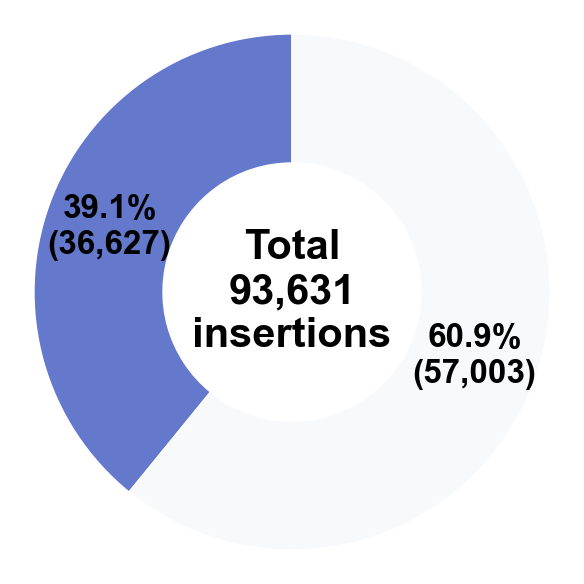

In [27]:
sizes = [36627, 93631 - 36627]
labels = ['Covered', 'Not Covered']
fig, ax = plt.subplots(figsize=(6, 6))

# Create the donut chart
wedges, texts, autotexts = ax.pie(
    sizes, 
    # labels=labels, 
    colors=[COLORS["functional"], COLORS["background"]],
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes)):,})',
    startangle=90,
    pctdistance=0.75,
    wedgeprops=dict(width=0.5, edgecolor='white'),
    textprops={'fontsize': 24, 'weight': 'bold'}
)

# Add title
# ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

# Add total count in center
ax.text(0, 0, f'Total\n{93631:,}\ninsertions', 
        ha='center', va='center', fontsize=30, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

plt.tight_layout()
plt.show()
plt.close()

In [40]:
import altair as alt

alt.Chart(gene_coverage.sort_values("rank")).mark_circle().encode(
    x=alt.X("Coverage:Q", title="The number of insertions per gene", scale=alt.Scale(domain=[0, 30], clamp=True)),
    y=alt.Y("rank:Q", title="The number of genes"),
).properties(
    width=200,
    height=400
) + alt.Chart(pd.DataFrame({'x': [6]})).mark_rule(strokeWidth=3).encode(
    x='x:Q',
    color=alt.value("red")
)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

Try enabling the VegaFusion data transformer which raises this limit by pre-evaluating data
transformations in Python.
    >> import altair as alt
    >> alt.data_transformers.enable("vegafusion")

Or, see https://altair-viz.github.io/user_guide/large_datasets.html for additional information
on how to plot large datasets.

alt.LayerChart(...)

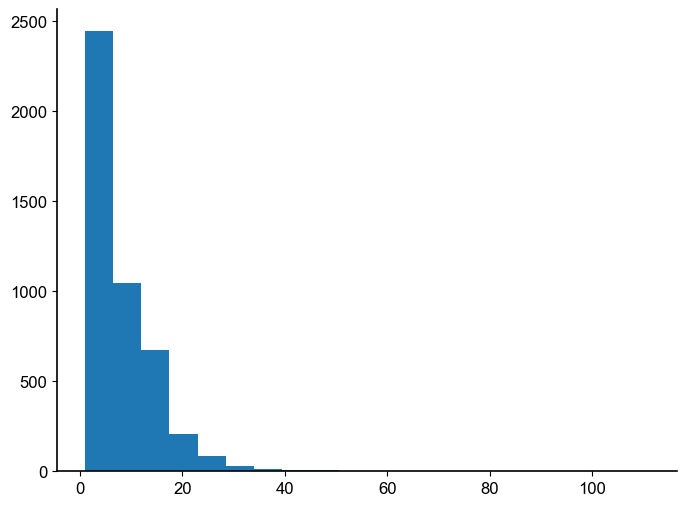

In [38]:
plt.hist(gene_coverage["Coverage"], bins=20)
plt.show()
plt.close()

In [34]:
gene_coverage

,Coverage,rank
Name,,
vps55,1,1.0
uvi15,1,2.0
new20,1,3.0
gcn3,1,4.0
ade6,1,5.0
...,...,...
mdn1,55,4515.0
tra2,62,4516.0
tra1,71,4517.0


In [38]:
annotations.loc[three_replicate_insertions_in_both]["Name"].value_counts()

Name
dhc1           75
sib1           70
tra1           39
sip1           38
vps1301        37
               ..
SPBC428.15      1
rhb1            1
pep7            1
new20           1
SPAC16E8.18     1
Name: count, Length: 4359, dtype: int64

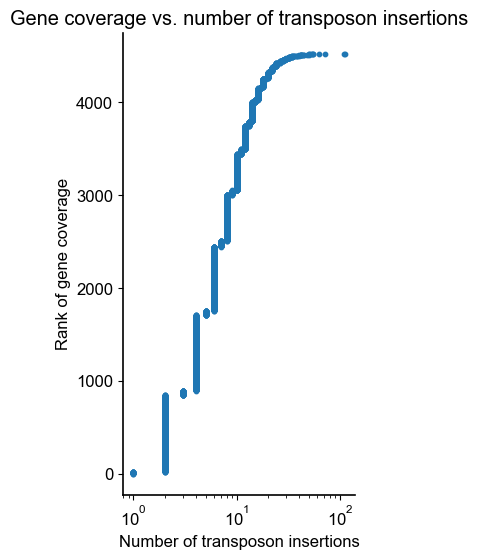

In [53]:
plt.figure(figsize=(3, 6))
plt.scatter(gene_coverage["count"], gene_coverage["rank"], s=10)
plt.xlabel("Number of transposon insertions")
plt.ylabel("Rank of gene coverage")
plt.title("Gene coverage vs. number of transposon insertions")
plt.xscale("log")
plt.show()
plt.close()